In [22]:
import os
import cv2
import random
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization, Conv2D, AveragePooling2D, Dense

In [23]:
# Goal: 60% train, 20% validate, 20% test -> 80% train+validate, 20% test
# Each patient must have all their lesions be in one set or the other, so we can't use train_test_split
# 318 total lesions -> 64*3=192=train, 64=validate, 62=test -> 256=train+validate, 62=test

folders = sorted(os.listdir("data_organized"))
train_val_patients = []
test_patients = []
test_count = 0
random.shuffle(folders)

for name in folders:
    train_val_patients.append(name)
    
for name in folders:
    _, count = name.split('+')
    # Fill up test_patients with 62 first
    count = int(count)
    if test_count+count <= 62:
        test_patients.append(name)
        test_count += count
        train_val_patients.remove(name)
        if test_count == 62:
            break
    elif test_count+count > 62:
        continue
        
print(test_count)

62


Shape of t2 train images is: (256, 32, 32, 3)
Shape of adc train images is: (256, 32, 32, 3)
Shape of labels is: (256,)


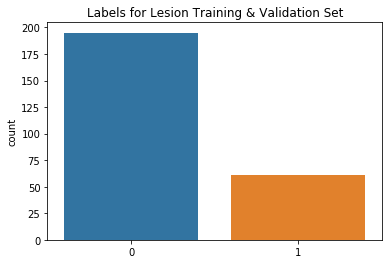

In [24]:
# Read in files from folders, store as np arrays of images (X_train) and clinsig labels (y_train)
# clinsig TRUE = 1, FALSE = 0
X_t2 = []
X_adc = []
y = []

for folder in train_val_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        if adc_t2 == 't2':
            if label == 'TRUE':
                y.append(1)
            else:
                y.append(0)
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array = np.asarray(img)
        lyr = np.expand_dims(array, axis=2)
        array = cv2.merge((lyr,lyr,lyr))    
#         print(array.shape)
#         plt.imshow(array, cmap='gray')
#         plt.show()
        if adc_t2 == 't2':
            X_t2.append(array)
        else:
            X_adc.append(array)

X_t2 = np.array(X_t2)
X_adc = np.array(X_adc)
y = np.array(y)

sns.countplot(y)
plt.title('Labels for Lesion Training & Validation Set')

print("Shape of t2 train images is:", X_t2.shape)
print("Shape of adc train images is:", X_adc.shape)
print("Shape of labels is:", y.shape)

In [25]:
# Now split this into training and validation set: 60% & 20% = 3/4 & 1/4
X = list(zip(X_t2, X_adc))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2)
X_train_t2, X_train_adc = zip(*X_train)
X_val_t2, X_val_adc = zip(*X_val)

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)
print("ntrain={}, nval={}".format(ntrain, nval))

ntrain=192, nval=64


In [26]:
 conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
# conv_base.summary()

In [27]:
chanDim = 3

model = tf.keras.Sequential()
model.add(conv_base)

model.add(Conv2D(32, (3, 3), padding="same")) # kernel_initializer=init ? 
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))

for i in range(9):
    model.add(Conv2D(32, (3, 3), padding="same")) 
    model.add(BatchNormalization(axis=chanDim))
    model.add(Activation("relu"))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(BatchNormalization(axis=chanDim))
    
model.add(AveragePooling2D(pool_size=(3, 3), padding="same"))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #Sigmoid function at the end because we have just two classes

# model.summary()

In [28]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

# binary_crossentropy loss because its a binary classification
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), metrics=['acc'])

Number of trainable weights before freezing the conv base: 292
Number of trainable weights after freezing the conv base: 80


In [29]:
batch_size = 32

train_datagen = ImageDataGenerator(
                    shear_range=0.2,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
val_datagen = ImageDataGenerator()

X_train_t2 = np.array(X_train_t2)
y_train = np.array(y_train)

X_val_t2 = np.array(X_val_t2)
y_val = np.array(y_val)

np.asarray(y_train).astype('float32').reshape((-1,1))
np.asarray(y_val).astype('float32').reshape((-1,1))

train_generator = train_datagen.flow(X_train_t2, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val_t2, y_val, batch_size=batch_size)

In [30]:
history = model.fit(train_generator,
                    steps_per_epoch=ntrain//batch_size,
                    epochs=170,
                    validation_data=val_generator,
                    validation_steps=nval//batch_size)

Epoch 1/170
6/6 [==============================] - 2s 279ms/step - loss: 0.6895 - acc: 0.5677 - val_acc: 0.8125 - val_loss: 0.6921
Epoch 2/170
6/6 [==============================] - 0s 79ms/step - loss: 0.7019 - acc: 0.5677 - val_acc: 0.8125 - val_loss: 0.6912
Epoch 3/170
6/6 [==============================] - 0s 77ms/step - loss: 0.6866 - acc: 0.5625 - val_acc: 0.8125 - val_loss: 0.6903
Epoch 4/170
6/6 [==============================] - 0s 79ms/step - loss: 0.7073 - acc: 0.5156 - val_acc: 0.8125 - val_loss: 0.6894
Epoch 5/170
6/6 [==============================] - 0s 78ms/step - loss: 0.6933 - acc: 0.5885 - val_acc: 0.8125 - val_loss: 0.6885
Epoch 6/170
6/6 [==============================] - 0s 77ms/step - loss: 0.6797 - acc: 0.6510 - val_acc: 0.8125 - val_loss: 0.6875
Epoch 7/170
6/6 [==============================] - 0s 78ms/step - loss: 0.6841 - acc: 0.6146 - val_acc: 0.8125 - val_loss: 0.6862
Epoch 8/170
6/6 [==============================] - 0s 79ms/step - loss: 0.7036 - acc: 0.5

6/6 [==============================] - 0s 75ms/step - loss: 0.5767 - acc: 0.7552 - val_acc: 0.8125 - val_loss: 0.5859
Epoch 64/170
6/6 [==============================] - 0s 75ms/step - loss: 0.5808 - acc: 0.7552 - val_acc: 0.8125 - val_loss: 0.5841
Epoch 65/170
6/6 [==============================] - 0s 75ms/step - loss: 0.5659 - acc: 0.7344 - val_acc: 0.8125 - val_loss: 0.5821
Epoch 66/170
6/6 [==============================] - 0s 75ms/step - loss: 0.5977 - acc: 0.7344 - val_acc: 0.8125 - val_loss: 0.5791
Epoch 67/170
6/6 [==============================] - 0s 75ms/step - loss: 0.5870 - acc: 0.7500 - val_acc: 0.8125 - val_loss: 0.5778
Epoch 68/170
6/6 [==============================] - 0s 75ms/step - loss: 0.5959 - acc: 0.7396 - val_acc: 0.8125 - val_loss: 0.5763
Epoch 69/170
6/6 [==============================] - 0s 75ms/step - loss: 0.5769 - acc: 0.7448 - val_acc: 0.8125 - val_loss: 0.5744
Epoch 70/170
6/6 [==============================] - 0s 75ms/step - loss: 0.5755 - acc: 0.7500 - 

6/6 [==============================] - 0s 74ms/step - loss: 0.5515 - acc: 0.7500 - val_acc: 0.8125 - val_loss: 0.5056
Epoch 126/170
6/6 [==============================] - 0s 74ms/step - loss: 0.5635 - acc: 0.7500 - val_acc: 0.8125 - val_loss: 0.5088
Epoch 127/170
6/6 [==============================] - 0s 75ms/step - loss: 0.5661 - acc: 0.7292 - val_acc: 0.8125 - val_loss: 0.4993
Epoch 128/170
6/6 [==============================] - 0s 74ms/step - loss: 0.5767 - acc: 0.7344 - val_acc: 0.8125 - val_loss: 0.4978
Epoch 129/170
6/6 [==============================] - 0s 75ms/step - loss: 0.5621 - acc: 0.7344 - val_acc: 0.8125 - val_loss: 0.4998
Epoch 130/170
6/6 [==============================] - 0s 75ms/step - loss: 0.5622 - acc: 0.7448 - val_acc: 0.8125 - val_loss: 0.5043
Epoch 131/170
6/6 [==============================] - 0s 76ms/step - loss: 0.5587 - acc: 0.7448 - val_acc: 0.8125 - val_loss: 0.5082
Epoch 132/170
6/6 [==============================] - 0s 74ms/step - loss: 0.5547 - acc: 0.

In [31]:
model.save_weights('models/model_t2_weights.h5')
model.save('models/model_t2_keras.h5')

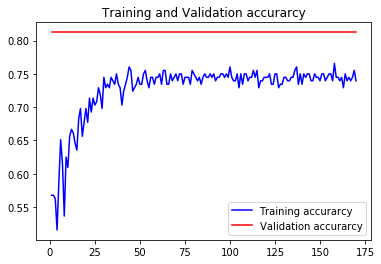

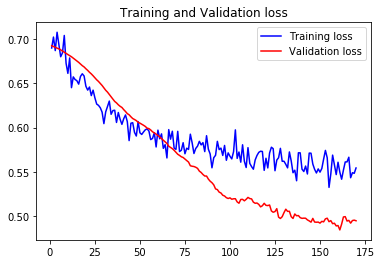

In [32]:
# Plot validation and losss

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

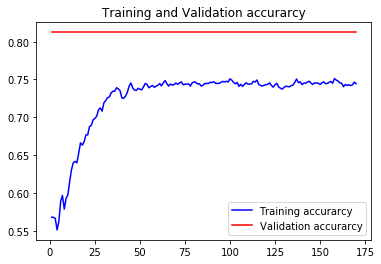

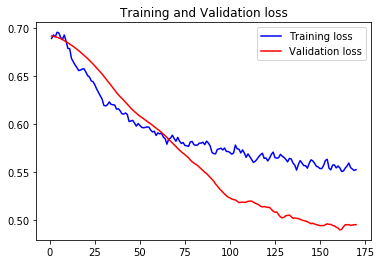

In [33]:
# Plot validation and losss with smoother lines

def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

#Plot figure
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accurarcy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.show()

plt.plot(epochs, smooth_plot(loss), 'b', label='Training loss')
plt.plot(epochs, smooth_plot(val_loss), 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [34]:
#Prepare test set

X_test_t2 = []
X_test_adc = []
y_test = []

for folder in test_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        if adc_t2 == 't2':
            if label == 'TRUE':
                y_test.append(1)
            else:
                y_test.append(0)
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array = np.asarray(img)
        lyr = np.expand_dims(array, axis=2)
        array = cv2.merge((lyr,lyr,lyr))
        if adc_t2 == 't2':
            X_test_t2.append(array)
        else:
            X_test_adc.append(array)

In [35]:
x = np.array(X_test_t2)
y = np.array(y_test)
total = len(x)
test_datagen = ImageDataGenerator()

correct = 0
i = 0
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    prediction = 1 if pred > 0.5 else 0
    actual = 1 if y[i] == 1 else 0
    correct += 1 if prediction == actual else 0
    i += 1
    if i == total:
        break
    
print('ACCURACY: {}%'.format(correct/total * 100))

ACCURACY: 79.03225806451613%
